In [1]:
from sklearn.manifold import TSNE
from collections import Counter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import umap
import h5py
from tqdm import tqdm
import sys
import os
from sklearn.decomposition import PCA
from openTSNE import TSNE
import matplotlib as mpl

/home/acomajuncosa/miniconda3/envs/camt/lib/python3.10/site-packages/umap/__init__.py:35: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Define root directory
# root = os.path.dirname(os.path.abspath(__file__))
root = "."
sys.path.append(os.path.join(root, "..", "src"))
from default import DATAPATH, CONFIGPATH

# Load pathogen info
# pathogen_code = sys.argv[1]
pathogen_code = 'mtuberculosis'
df = pd.read_csv(os.path.join(CONFIGPATH, 'pathogens.csv'))
row = df.loc[df["code"].eq(pathogen_code)]
if row.empty: 
    raise SystemExit(f"Unknown code: {pathogen_code}")
pathogen = row.iloc[0]["pathogen"]

# Define output directory
OUTPUT = os.path.join(root, "..", "output")

In [3]:
def load_ecfp_all(h5_path):
    """Load all ECFP (Morgan count) fingerprints.

    Parameters
    ----------
    h5_path : str
        Path to the HDF5 file containing datasets "SMILES" and "X_morgan".

    Returns
    -------
    dict[str, np.ndarray]
        Mapping {chembl_id: fingerprint (np.int8, shape (nBits,))}.
    """
    with h5py.File(h5_path, "r") as f:
        meta = f["SMILES"][:, 3].astype(str)
        fps  = f["X_morgan"][:]  # Load ALL

    return {cid: fp for cid, fp in zip(meta, fps)}

# Loading Morgan fingerprints
PATH_TO_ECFPs = os.path.join(DATAPATH, "chembl_processed", "ChEMBL_ECFPs.h5")
ecfps = load_ecfp_all(PATH_TO_ECFPs)

In [4]:
# def fit_umap_reference(ecfp_dict, n_ref=10_000, seed=42):
#     """
#     Sample n_ref compounds, fit UMAP, and persist:
#       - fitted reducer
#       - reference ids
#       - reference embedding
#     """

#     # Sample n_ref ids
#     ids_all = np.array(list(ecfp_dict.keys()))
#     rng = np.random.default_rng(seed)
#     ref_ids = rng.choice(ids_all, size=n_ref, replace=False)

#     # Build matrix
#     X_ref = np.stack([ecfp_dict[i] for i in ref_ids], axis=0)

#     # Binarize
#     X_ref = (X_ref > 0).astype(np.uint8)

#     # UMAP prefers float32 for speed/memory
#     X_ref = X_ref.astype(np.float32, copy=False)

#     reducer = umap.UMAP(
#         n_neighbors=30,
#         min_dist=0.15,
#         n_components=2,
#         metric="jaccard",
#         random_state=seed,
#         verbose=True,
#     )

#     emb_ref = reducer.fit_transform(X_ref)

#     # os.makedirs(outdir, exist_ok=True)
#     # joblib.dump(reducer, os.path.join(outdir, "umap_reducer.joblib"))
#     # np.save(os.path.join(outdir, "umap_ref_ids.npy"), ref_ids)
#     # np.save(os.path.join(outdir, "umap_ref_emb.npy"), emb_ref)

#     return reducer, ref_ids, emb_ref

# reducer, ref_ids, ref_emb = fit_umap_reference(ecfps, n_ref=10_000, seed=42)

def fit_opentsne_with_bg(ecfp_dict, ids, n_bg=10_000, seed=42, perplexity=30, pca_dim=4, n_jobs=16):
    """
    Fit openTSNE on [ids] + [random background sample from ecfp_dict], ensuring
    the background sample contains no elements from ids.

    Returns
    -------
    all_ids : np.ndarray
        Concatenated ids: [ids..., bg_ids...].
    emb : np.ndarray
        2D embedding aligned to all_ids, shape (len(all_ids), 2).
    """
    
    ids = np.array(list(ids))
    ids_set = set(ids.tolist())
    rng = np.random.default_rng(seed)

    # sample background from keys excluding ids
    pool = np.array([k for k in ecfp_dict.keys() if k not in ids_set])
    if len(pool) == 0:
        raise ValueError("Background pool is empty after excluding ids.")
    if n_bg > len(pool):
        raise ValueError(f"Requested n_bg={n_bg}, but only {len(pool)} non-id keys available.")

    bg_ids = rng.choice(pool, size=n_bg, replace=False)

    # safety check (should never trigger, but keeps it explicit)
    if np.intersect1d(bg_ids, ids).size:
        raise RuntimeError("Background sample overlaps with ids (unexpected).")

    all_ids = np.concatenate([ids, bg_ids])

    X = (np.stack([ecfp_dict[i] for i in all_ids]) > 0).astype(np.float32)

    print("Doing PCA...")
    if pca_dim is not None:
        d = min(pca_dim, X.shape[1], X.shape[0] - 1)
        X = PCA(n_components=d, random_state=seed, svd_solver="randomized").fit_transform(X)

    print("Doing tSNE...")
    perp = min(float(perplexity), max(5.0, (X.shape[0] - 1) / 3.0))
    emb = TSNE(n_components=2, perplexity=perp, random_state=seed, n_jobs=n_jobs, negative_gradient_method="fft", n_iter=100).fit(X)
    return all_ids, np.asarray(emb)

def scatter_density(ax, xy, size_min=10, size_max=120, cmap="viridis", alpha=0.9, zorder=3):
    """
    Plot points sized+colored by KDE density.
    xy: (n,2)
    Returns: PathCollection
    """
    xy = np.asarray(xy)
    x, y = xy[:, 0], xy[:, 1]

    kde = gaussian_kde(np.vstack([x, y]))
    dens = kde(np.vstack([x, y]))  # (n,)

    # normalize density to 0..1
    d0, d1 = np.min(dens), np.max(dens)
    dn = (dens - d0) / (d1 - d0 + 1e-12)

    sizes = size_min + dn * (size_max - size_min)

    sc = ax.scatter(
        x, y,
        c=dens,
        s=sizes,
        cmap=cmap,
        alpha=alpha,
        edgecolors="none",
        zorder=zorder,
    )
    return sc

In [5]:
# Number of compounds, activities and assays
raw = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "mtuberculosis_ChEMBL_raw_data.csv.gz"))
activities_raw = len(raw)
compounds_raw = len(set(raw['compound_chembl_id']))
cleaned = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "mtuberculosis_ChEMBL_cleaned_data.csv.gz"))
activities_cleaned = len(cleaned)
compounds_cleaned = len(set(cleaned['compound_chembl_id']))
assays_raw = len(pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_raw.csv")))
assays_cleaned = len(pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv")))
del raw, cleaned

In [6]:
# Assay type
df = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv"))
assay_type = Counter(df['assay_type'])
assay_type = [assay_type['F'] / sum(assay_type.values()), (assay_type['F'] + assay_type['B']) / sum(assay_type.values()), 1][::-1]
target_type = Counter(df['target_type'])
target_type = [target_type['ORGANISM'] / sum(target_type.values()), (target_type['ORGANISM'] + target_type['SINGLE PROTEIN']) / sum(target_type.values()), 1][::-1]
assay_organism = Counter(df['assay_organism'])
assay_organism = [assay_organism[pathogen_code] / sum(assay_organism.values()), 1]

In [7]:
# Load reference compounds from pathogen
reference_compounds = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "compound_counts.csv.gz"))['compound_chembl_id'].tolist()[:10_000]
N_REF = len(reference_compounds)
all_ids, emb = fit_opentsne_with_bg(ecfps, ids=reference_compounds, n_bg=N_REF*3, seed=42, pca_dim=16)

Doing PCA...
Doing tSNE...


In [8]:
# Cumulative coverage chemical space per assay
ASSAYS_CLEANED = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv"))
assays_pathogen = set(ASSAYS_CLEANED['assay_id'])

# Dict mapping assay_id, activity_type and unit to a set of compound ChEMBL IDs
ChEMBL = pd.read_csv(os.path.join(OUTPUT, pathogen_code, f"{pathogen_code}_ChEMBL_cleaned_data.csv.gz"), low_memory=False)
compounds_pathogen = set(ChEMBL['compound_chembl_id'])
ASSAY_TO_COMPOUNDS = defaultdict(set)
for assay_id, activity_type, unit, compound_chembl_id in ChEMBL[["assay_chembl_id", "activity_type", "unit", "compound_chembl_id"]].values:
    if assay_id in assays_pathogen:
        ASSAY_TO_COMPOUNDS[(assay_id, activity_type, unit)].add(compound_chembl_id)
del ChEMBL

In [9]:
CUM_CPDS = set()
CUM_PROP = []
for assay_id, activity_type, unit in tqdm(ASSAYS_CLEANED[["assay_id", "activity_type", "unit"]].values):
    CUM_CPDS = CUM_CPDS.union(ASSAY_TO_COMPOUNDS[(assay_id, activity_type, unit)])
    CUM_PROP.append(len(CUM_CPDS) / len(compounds_pathogen))
ASSAYS_CLEANED['cum_prop'] = CUM_PROP
CPDS = ASSAYS_CLEANED['cpds'].tolist()

100%|██████████| 10532/10532 [00:55<00:00, 189.60it/s]


In [17]:
def left_to_right(y_left):
    return 10**(5*y_left)

def right_to_left(y_right):
    y_right = np.asarray(y_right)
    y_right = np.maximum(y_right, 1e-100)
    return np.log10(y_right) / 5

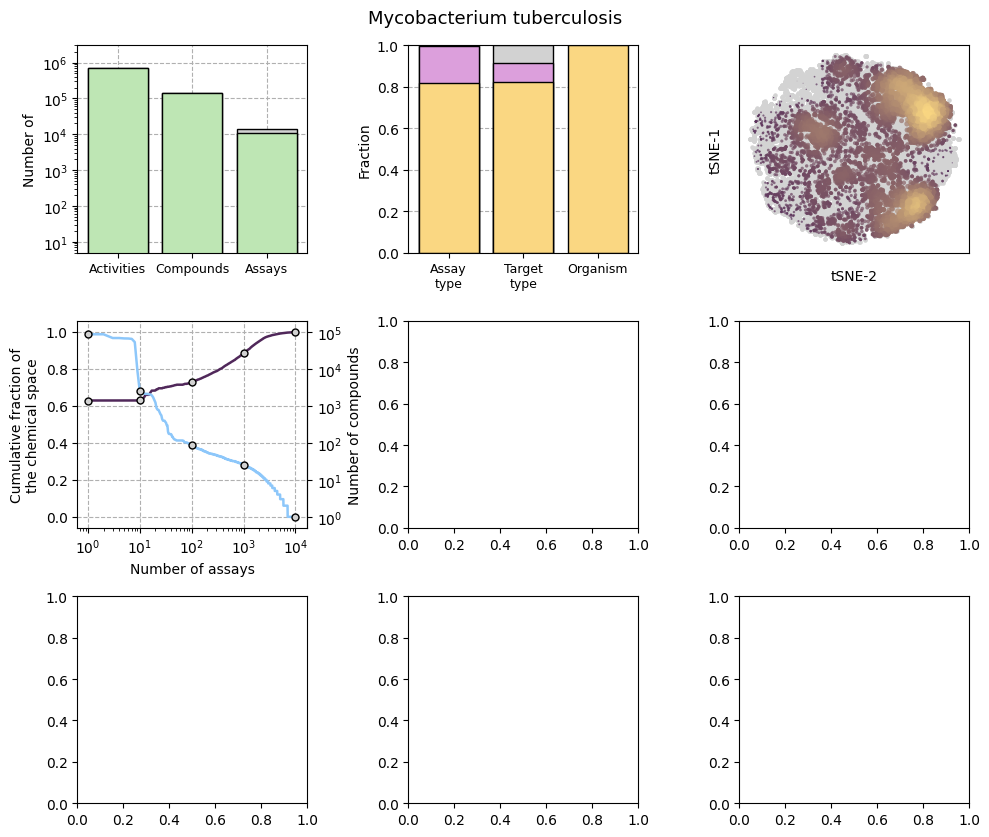

In [33]:
fig, ax = plt.subplots(3, 3, figsize=(10, 8.5))

# Number of compounds, activities and assays
ax[0][0].bar([0, 0], [activities_raw, activities_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].bar([1, 1], [compounds_raw, compounds_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].bar([2, 2], [assays_raw, assays_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].grid(linestyle='--', zorder=-2)
ax[0][0].set_yscale('log')
ax[0][0].set_yticks([10**1, 10**2, 10**3, 10**4, 10**5, 10**6])
ax[0][0].set_ylim([5, 3*10**6])
ax[0][0].set_xticks([0, 1, 2])
ax[0][0].set_xticklabels(['Activities', 'Compounds', 'Assays'], size=9)
ax[0][0].set_ylabel("Number of")

# Fraction assays
ax[0][1].bar([0, 0, 0], assay_type, zorder=2, color=['#D2D2D2', '#DC9FDC', '#FAD782'], ec='k')
ax[0][1].bar([1, 1, 1], target_type, zorder=2, color=['#D2D2D2', '#DC9FDC', '#FAD782'], ec='k')
ax[0][1].bar([2, 2], assay_organism, zorder=2, color=['#D2D2D2', '#FAD782'], ec='k')
ax[0][1].set_ylabel("Fraction")
ax[0][1].set_ylim([0, 1])
ax[0][1].grid(linestyle='--', zorder=-2)
ax[0][1].set_xticks([0, 1, 2])
ax[0][1].set_xticklabels(['Assay\ntype', 'Target\ntype', 'Organism'], size=9)

# 2D visualization
ax[0][2].scatter(emb[N_REF:][:, 0], emb[N_REF:][:, 1], s=5, c='lightgray')
start_hex, end_hex = "#50285A", "#FAD782"
cmap = mpl.colors.LinearSegmentedColormap.from_list("two_color", [start_hex, end_hex], N=256)
sc = scatter_density(ax[0][2], emb[:N_REF, :2], size_min=0, size_max=30, cmap=cmap, alpha=0.7)
ax[0][2].set_yticks([])
ax[0][2].set_xticks([])
ax[0][2].set_ylabel("tSNE-1", labelpad=12)
ax[0][2].set_xlabel('tSNE-2', labelpad=12)

# Cumulative fraction chemical space
ax[1][0].set_ylim([-0.06, 1.06])
ax[1][0].grid(linestyle='--', zorder=-2)
ax[1][0].plot([i+1 for i in range(len(CUM_PROP))], CUM_PROP, c="#50285A", lw=1.8)
ax[1][0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
x = [1, 10, 100, 1000, 10000]
y = [CUM_PROP[i-1] for i in x]
ax[1][0].scatter(x, y, zorder=2, ec="k", s=25, c='#D2D2D2')
ax[1][0].set_xlabel("Number of assays")
ax[1][0].set_ylabel("Cumulative fraction of\nthe chemical space")
ax[1][0].set_xscale('log')
ax[1][0].set_xticks([1, 10, 100, 1000, 10000])
secax = ax[1][0].secondary_yaxis('right', functions=(left_to_right, right_to_left))
secax.set_ylabel("Number of compounds")
secax.set_yticks([1, 10, 100, 1_000, 10_000, 100_000])
secax.set_yticklabels([r"$10^0$", r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"])
ax[1][0].plot([i+1 for i in range(len(CPDS))], right_to_left(CPDS), c="#8DC7FA", lw=1.8, zorder=2)
y = [right_to_left(CPDS[i-1]) for i in x]
ax[1][0].scatter(x, y, zorder=2, ec="k", s=25, c='#D2D2D2')

plt.suptitle(pathogen, size=13)
plt.tight_layout()
plt.show()

In [28]:
[CPDS[i-1] for i in x]

[86589, 2468, 85, 25, 1]